# Neuronové sítě

There are many frameworks for neural networks: `tensorflow` , `pytorch`, `mxnet`. Also `scikit-learn` has its own neural network implementation. But it's very useful to know the fundamentals, because it allows us to use better those tools, and to extend them if needed.

In this tutorial we will implement a toy version of a neural network in pure `numpy`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Definujme aktivační funkci a počáteční dataset

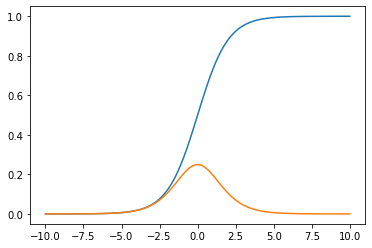

In [2]:
# sigmoida společně s její derivací
def sigmoid(x, deriv=False):
    if(deriv==True):
        return sigmoid(x)*(1-sigmoid(x))
    return 1/(1+np.exp(-x))

xxx = np.linspace(-10,10,100)
plt.plot(xxx, sigmoid(xxx))
plt.plot(xxx, sigmoid(xxx, deriv = True))

In [3]:
# input dataset
X = np.array([  [0,0],
                [0,1],
                [1,0],
                [1,1] ])
    
# output dataset            
y = np.array([[0,1,0,1]]).T

In [4]:
def plot_X_y(X,y):
    color = {0:'blue', 1:'red'}
    colors = [color[y[ix][0]] for ix in range(len(y))]
    plt.scatter(X[:,0],X[:,1], c=colors)
    plt.title("Data set")

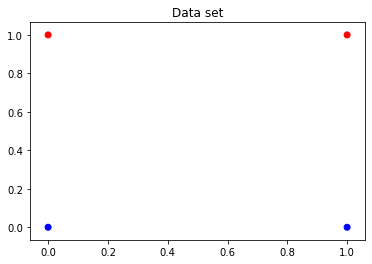

In [5]:
plot_X_y(X,y)

Pojďme definovat naši třídu pro neuronovou síť: jediným parametrem bude počet vstupů

Implementujeme čtyři její metody:
- `forward`: multiplying the input by the weights across layers.
- `backward`: performing update of the weights, given the output.
- `fit`: which combines these two in a loop.
- `predict`: an alias for `forward` basically, just to make it `scikit-learn`-like :)

In [21]:
class NeuralNet:
    def __init__(self, input_dim):
        # seed random numbers to make calculation deterministic
        np.random.seed(1)

        # initialize weights randomly with mean 0
        self.w = np.random.randn(input_dim,1)
        
        # Learning rate
        self.lr = 0.01
        
        # Number of iterations
        self.n_iter = int(1e4)
        
    def forward(self,X):
        l1 = sigmoid(np.dot(X,self.w))
        return l1
    
    def backward(self,X,y):
        # do výsledku uložíme chybu
        res =  y - self.forward(X)
        # tu propagujeme dále
        # - spočteme derivaci ztrátové funkce
        res = -2*res
        # - vynásobíme derivací aktivační funkce 
        res = res*sigmoid(np.dot(X, self.w), deriv = True)
        # - vynásobíme derivací vnitřního potenciálu
        res = np.dot(X.T, res)
        # výsledkem je gradient - jakožto vektor derivací podle obou koeficientů
        grad = res / y.shape[0]
#         print(grad)
        
        # provedeme update vah
        self.w -= self.lr*grad
    
    def fit(self,X,y):
        for _ in range(self.n_iter):
            # backward step
            self.backward(X,y)
   
    def predict(self,X):
        return (self.forward(X) > 0.5).astype("int32")
    
    def predict_proba(self, X):
        return self.forward(X)
        

Pojďme to vyzkoušet

In [22]:
nn = NeuralNet(input_dim=2)
nn.fit(X,y)
nn.predict(X)

array([[0],
       [1],
       [0],
       [1]], dtype=int32)

Porovnáme s originálním výstupem:

In [23]:
y

array([[0],
       [1],
       [0],
       [1]])

Problematický je bod $[0,0]$.

In [24]:
# Koeficienty
nn.w

array([[-1.22513719],
       [ 2.80583778]])

### Vizualizace rozhodovací hranice
$$w_1x_1 + w_2 x_2 = 0$$

(-0.1, 1.1)

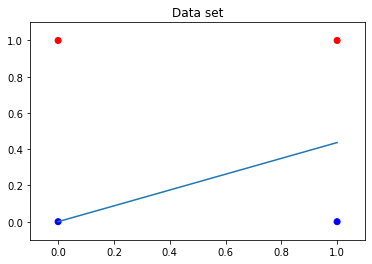

In [25]:
xgrid = np.linspace(0,1,100)

plot_X_y(X,y)
plt.plot(xgrid, -nn.w[0]/nn.w[1]*xgrid)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

** Problémem je počátek. Je to způsobeno tím, že rozhodovací hranice jím vždy prochází!**

### Task 1 - opravte to

In [50]:
### Your code here

class NeuralNet2:
    def __init__(self, input_dim):
        # seed random numbers to make calculation deterministic
        np.random.seed(1)

        # initialize weights randomly with mean 0
        self.w = np.random.randn(input_dim,1)
        self.w0 = np.random.randn(1)
        # Learning rate
        self.lr = 0.01
        
        # Number of iterations
        self.n_iter = int(1e4)
        
    def forward(self,X):
        l1 = sigmoid(np.dot(X,self.w) + self.w0)
        return l1
    
    def backward(self,X,y):
        # do výsledku uložíme chybu
        res =  y - self.forward(X)
        # tu propagujeme dále
        # - spočteme derivaci ztrátové funkce
        res = -2*res
        # - vynásobíme derivací aktivační funkce 
        res = res * sigmoid(np.dot(X, self.w) + self.w0, deriv = True)
        
        grad_w0 = np.sum(res)/y.shape[0]
        # - vynásobíme derivací vnitřního potenciálu
        res = np.dot(X.T, res)
        # výsledkem je gradient - jakožto vektor derivací podle obou koeficientů
        grad = res / y.shape[0]
#         print(grad)
        
        # provedeme update vah
        self.w -= self.lr*grad
        self.w0 -= self.lr*grad_w0
    
    def fit(self,X,y):
        for _ in range(self.n_iter):
            # backward step
            self.backward(X,y)
   
    def predict(self,X):
        return (self.forward(X) > 0.5).astype("int32")
    
    def predict_proba(self, X):
        return self.forward(X)
        




In [53]:
nn = NeuralNet2(input_dim=2)
nn.fit(X,y)
print(nn.predict(X))
print(nn.predict_proba(X))
print(y)

[[0]
 [1]
 [0]
 [1]]
[[0.15681561]
 [0.87695334]
 [0.14910644]
 [0.87038629]]
[[0]
 [1]
 [0]
 [1]]


(-0.1, 1.1)

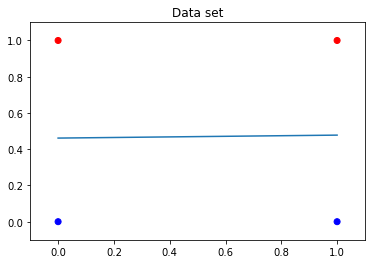

In [54]:
xgrid = np.linspace(0,1,100)

plot_X_y(X,y)
plt.plot(xgrid, -nn.w0[0]/nn.w[1] - nn.w[0]/nn.w[1]*xgrid)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

### Task 2 - zkuste, zda tento jednoduchý perceptron dokáže zvládnout logické funkce AND a OR
- pokaždé vykreslete rozhodovací hranici

In [59]:
### Your code here
X_and = np.array([[0,0],
                [0,1],
                [1,0],
                [1,1] ])
y_and = np.array([[0,0,0,1]]).T

X_or = np.array([[0,0],
                [0,1],
                [1,0],
                [1,1] ])
y_or = np.array([[0,1,1,1]]).T

## AND

In [60]:
nn = NeuralNet2(input_dim=2)
nn.fit(X_and,y_and)
print(nn.predict(X_and))
print(y_and)

[[0]
 [0]
 [0]
 [1]]
[[0]
 [0]
 [0]
 [1]]


(-0.1, 1.1)

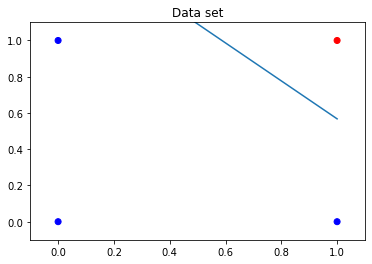

In [63]:
xgrid = np.linspace(0,1,100)

plot_X_y(X_and,y_and)
plt.plot(xgrid, -nn.w0[0]/nn.w[1] - nn.w[0]/nn.w[1]*xgrid)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

## OR

In [65]:
nn = NeuralNet2(input_dim=2)
nn.fit(X_or,y_or)
print(nn.predict(X_or))
print(y_or)

[[0]
 [1]
 [1]
 [1]]
[[0]
 [1]
 [1]
 [1]]


(-0.1, 1.1)

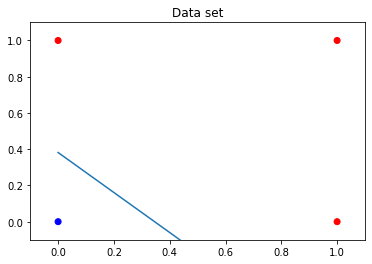

In [67]:
xgrid = np.linspace(0,1,100)

plot_X_y(X_or,y_or)
plt.plot(xgrid, -nn.w0[0]/nn.w[1] - nn.w[0]/nn.w[1]*xgrid)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

### Problém nastane až s logickou funkcí XOR

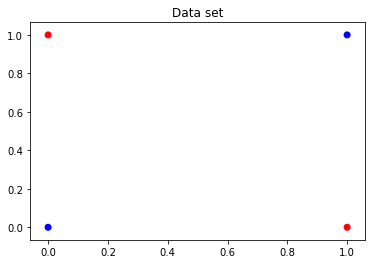

In [68]:
# input dataset
X_xor = np.array([[0,0],
                [0,1],
                [1,0],
                [1,1]])
    
# output dataset            
y_xor = np.array([[0,1,1,0]]).T

plot_X_y(X_xor,y_xor)

In [69]:
nn = NeuralNet2(input_dim=2)
nn.fit(X_xor,y_xor)
print(nn.predict(X_xor))
print(y_xor)

[[0]
 [0]
 [1]
 [1]]
[[0]
 [1]
 [1]
 [0]]


(-0.1, 1.1)

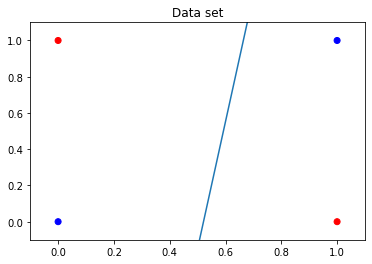

In [72]:
xgrid = np.linspace(0,1,100)

plot_X_y(X_xor,y_xor)
plt.plot(xgrid, -nn.w0[0]/nn.w[1] - nn.w[0]/nn.w[1]*xgrid)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

**Fun fact:** `sklearn`'s implementation with a hidden layer can train badly! This is because you get stuck in local minima.

In [75]:
from sklearn.neural_network import MLPClassifier
for i in range(10):
    mlp = MLPClassifier(hidden_layer_sizes=(2,), random_state=i)
    mlp.fit(X_xor,y_xor)
    print("Error with seed {}: {}".format(i,mlp.score(X_xor,y_xor)))

/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Error with seed 0: 0.5
Error with seed 1: 0.5
Error with seed 2: 0.5
Error with seed 3: 0.5
Error with seed 4: 0.75


/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Error with seed 5: 0.5
Error with seed 6: 0.5
Error with seed 7: 0.5
Error with seed 8: 0.75
Error with seed 9: 0.5


/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/filip/.local/lib/python3.8/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [74]:
mlp.n_layers_

3

### Task 3 - implementujte vícevrstvou síť, která zvládne XOR
- nejprve zkuste, zda to zvládne scikit s více vrstvami
- poté zkuste vlastní řešení pomocí co nejmenšího počtu neuronů (jedna skrytá vrstva se dvěma neurony a RELU stačí) 
- neimplementujte backpropagation (který to moc nezvládá) ale váhy nastavte natvrdo

$$ \text{RELU}(x) = \max(0, x)$$

In [ ]:
### Your code here



### Bonusový Task - Prozkoumejte [Tensorflow playground](http://playground.tensorflow.org)